In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, print_results,sphere_mask,fourier_filter,get_gradient_P

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Documents/June_8_2016_navs/'
ranges = ['2_5_to_12_5']
axes_dict = {'x':'z'}
print axes_dict

{'x': 'z'}


In [6]:
def normalize(volume, scale):
    assert((volume >= 0).all())
    return volume * scale

In [7]:
def Max_displacement(dRM, R_axis, dt):
    rad = 100
    trans_R = rad*np.sqrt(3-np.trace(dRM))
    E_max = np.sqrt(trans_R**2 + 2*trans_R*np.linalg.norm(dt-(dt.T.dot(R_axis))*R_axis) + (dt.T).dot(dt))
    return trans_R, E_max

In [8]:
def RMS_Rotation(dRM):
    return np.arccos((np.trace(dRM)-1)/2.)*180/np.pi

def RMS_Translation(dt):
    t = dt
    return np.sqrt((t.T).dot(t))
def RMS_Translation_R(dRM):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A)))

def RMS(dRM, dt, res_f):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A))+ (dt.T).dot(dt))
    
from conversion import rotation_matrix_fromq, rotation_matrix_from_params
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    true_RM = rotation_matrix_fromq(rot_angle[0],wx,wy,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], true_RM

def get_params(errors, Ps, res):
    params = Ps[-1]
    RM = rotation_matrix_from_params(-params[3:])
    return  params[:3]*res, RM

In [9]:
keys = ['x']
def compute_RMS(cost_dict_6_4, cost_dict_8, cost_dict_10, grad_idx = 2):
    true_params = []
    Max_dis_6_4 = []
    Max_dis_R_6_4 = []
    RMS_ls_6_4 = []
    RMS_rotation_ls_6_4 = []
    RMS_translation_ls_6_4 = []
    RMS_trans_R_6_4 = []
    counter_6_4 = []
    
    Max_dis_8 = []
    Max_dis_R_8 = []
    RMS_ls_8 = []
    RMS_rotation_ls_8 = []
    RMS_translation_ls_8 = []
    RMS_trans_R_8 = []
    counter_8 = []
    
    Max_dis_10 = []
    Max_dis_R_10 = []
    RMS_ls_10 = []
    RMS_rotation_ls_10 = []
    RMS_translation_ls_10 = []
    RMS_trans_R_10 = []
    counter_10 = []
    for ix, rot_ax in enumerate(keys):
        for rang in ranges:
            ref = rep_to_angle(0,rang)
            for rep in xrange(1,36):
                rot_angle = rep_to_angle(rep,rang)
                true_params.append(rot_angle)
                true_t, true_RM = get_true_params(rot_angle,rot_ax)

                res = '6_4'
                res_f =  6.4
                rad = res_to_rad(res)
                errors, Ps, counter = cost_dict_6_4[grad_idx][rot_angle]
                theta = np.linalg.norm(Ps[-1][3:])*180.0/np.pi
                #errors, Ps = cost_dict_6_4[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_6_4.append(E_Max)
                Max_dis_R_6_4.append(max_trans_R)
                RMS_ls_6_4.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_6_4.append(theta)
                RMS_translation_ls_6_4.append(RMS_Translation(dt))
                RMS_trans_R_6_4.append(RMS_Translation_R(dR))
                counter_6_4.append(counter)

                res = '8'
                res_f =  8.0
                rad = res_to_rad(res)
                errors, Ps, counter = cost_dict_8[grad_idx][rot_angle]
                theta = np.linalg.norm(Ps[-1][3:])*180.0/np.pi
                #errors, Ps = cost_dict_8[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_8.append(E_Max)
                Max_dis_R_8.append(max_trans_R)
                RMS_ls_8.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_8.append(theta)
                RMS_translation_ls_8.append(RMS_Translation(dt))
                RMS_trans_R_8.append(RMS_Translation_R(dR))
                counter_8.append(counter)

                res = '10'
                res_f =  10.0
                rad = res_to_rad(res)           
                errors, Ps, counter = cost_dict_10[grad_idx][rot_angle]
                theta = np.linalg.norm(Ps[-1][3:])*180.0/np.pi
                #errors, Ps = cost_dict_10[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_10.append(E_Max)
                Max_dis_R_10.append(max_trans_R)
                RMS_ls_10.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_10.append(theta)
                RMS_translation_ls_10.append(RMS_Translation(dt))
                RMS_trans_R_10.append(RMS_Translation_R(dR))
                counter_10.append(counter)
                
    return [true_params,
            RMS_ls_6_4,RMS_ls_8,RMS_ls_10,
            RMS_rotation_ls_6_4,RMS_rotation_ls_8,RMS_rotation_ls_10, 
            RMS_translation_ls_6_4,RMS_translation_ls_8,RMS_translation_ls_10,
            Max_dis_6_4,Max_dis_8,Max_dis_10,
            Max_dis_R_6_4,Max_dis_R_8,Max_dis_R_10,
            RMS_trans_R_6_4, RMS_trans_R_8, RMS_trans_R_10,
            counter_6_4, counter_8, counter_10]

In [65]:
def plot_RMS(RMS_ls, interpolation):
    x = np.arange(0,70,1)
    labels = RMS_ls[0][:70]
    resolutions = ['6.4','8','10']
    for idx in xrange(3): # RMS
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+1][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    for idx in xrange(3): # RMS for Rotations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+4][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s Rotation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
    for idx in xrange(3): # RMS for Translations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+7][i*70:(i+1)*70], '^' ,label = 'translation axis: '+ axes_dict[axes_dict.keys()[i]])
        plt.title('%s Translation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [66]:
from scipy.stats import rankdata
def signed_rank_test(array1,array2):
    # Compute difference
    diff = np.array(array1)-np.array(array2)
    # record signs
    sign = np.sign(diff)
    # take absolute value
    abs_diff = abs(diff)

    # find indexes that sort an array
    indexes = np.argsort(abs_diff)

    # sorted difference and signs
    sorted_diff_all = abs_diff[indexes]
    sorted_sign_all = sign[indexes]

    # delete zero differences
    mask = sorted_diff_all >= 1e-10
    sorted_diff = sorted_diff_all[mask]
    sorted_sign = sorted_sign_all[mask]

    # Find max W
    N = len(sorted_diff)
    max_W = N*(N+1)/2.
    sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
    #print N, max_W

    # final difference
    final_diff = sorted_diff*sorted_sign

    # find rank
    rank = rankdata(sorted_diff)

    # final rank
    final_rank = sorted_sign*rank

    # score
    w = np.sum(final_rank)
    
    # z score
    z = (w-0.5)/sigma_w
    return N, max_W, w, z

In [67]:
date = 'july26_dict'

## Run Gauss Newton with BSplines on all data

In [54]:
cost_dict_bsplines_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_BSpline_GN2_6_4mm.p'%date,'rb'))
cost_dict_bsplines_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_BSpline_GN2_8mm.p'%date,'rb'))
cost_dict_bsplines_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_BSpline_GN2_10mm.p'%date,'rb'))

# RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10,1)
# RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10,2)

#plot_RMS(RMS_bspline, 'bspline')

## Run Gauss Newton with Trilinear on all data

In [55]:
cost_dict_linear_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_Linear_GN2_6_4mm.p'%date,'rb'))
cost_dict_linear_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_Linear_GN2_8mm.p'%date,'rb'))
cost_dict_linear_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_Linear_GN2_10mm.p'%date,'rb'))


# RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)
# RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)

#plot_RMS(RMS_linear, 'linear')

## Run Gauss Newton with Tricubic on all data

In [56]:
cost_dict_cubic_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_tricubic_GN2_6_4mm.p'%date,'rb'))
cost_dict_cubic_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_tricubic_GN2_8mm.p'%date,'rb'))
cost_dict_cubic_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/%s_PE_AP_tricubic_GN2_10mm.p'%date,'rb'))

# RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)
# RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)

#plot_RMS(RMS_cubic, 'cubic')

In [57]:
RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10, 2)
RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)
RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)

In [58]:
RMS_bspline1 = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10, 1)
RMS_cubic1 = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 1)
RMS_linear1 = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 1)

In [59]:
pickle.dump(RMS_bspline,open('RMS_bspline_%s.p'%date,'wb'))
pickle.dump(RMS_cubic,open('RMS_cubic_%s.p'%date,'wb'))
pickle.dump(RMS_linear,open('RMS_linear_%s.p'%date,'wb'))

pickle.dump(RMS_bspline1,open('RMS_bspline1_%s.p'%date,'wb'))
pickle.dump(RMS_cubic1,open('RMS_cubic1_%s.p'%date,'wb'))
pickle.dump(RMS_linear1,open('RMS_linear1_%s.p'%date,'wb'))

In [68]:
large_rot_data_ls = []
interps = ['bspline','cubic','linear']
dates = ['june8','july15','july26']
for interp in interps:
    for d in dates:
        RMS_bspline = pickle.load(open('RMS_%s_%s.p'%(interp,d),'rb'))
        large_rot_data_ls.append(RMS_bspline)
print len(large_rot_data_ls)
pickle.dump(large_rot_data_ls,open('large_rot_data_ls.p','wb'))

large_rot_data_ls_1 = []
interps = ['bspline1','cubic1','linear1']
dates = ['june8','july15','july26']
for interp in interps:
    for d in dates:
        RMS_bspline = pickle.load(open('RMS_%s_%s.p'%(interp,d),'rb'))
        large_rot_data_ls_1.append(RMS_bspline)
print len(large_rot_data_ls_1)
pickle.dump(large_rot_data_ls_1,open('large_rot_data_ls_1.p','wb'))

9
9


In [68]:
resolutions = ['6.4', '8', '10']
colors = ['red', 'blue', 'green']

In [61]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go

In [62]:
c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 9)]
colors = []
for color in c:
    colors += [color]*70
    
xx = np.ones(420)

rot_axes = ['x','y','z','xy','yz','xz']
ax_labels = []
for ax in rot_axes:
    ax_labels += [ax]*70
labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
          '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
          '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']

In [63]:
def plotly_scatter(idx_ls, title, ylabel):
    l = []
    index = 1

    for idx in idx_ls:
        for ii, ls in enumerate(large_rot_data_ls_1):
            subj_idx = (ii+1) % 3
            trace0= go.Scatter(
                x= ((xx * index) - 0.3) + (0.2*subj_idx),
                y= ls[idx],
                mode= 'markers',
                marker= dict(size= 14,
                            line= dict(width=1),
                            color= c[index-1],
                            opacity= 0.3
                           ),
                name= 'subject %s' % subj_idx,
                text= 'x') # The hover text goes here... 
            l.append(trace0);
            if(subj_idx) == 0:
                index += 1

    layout= go.Layout(
        title= title,
        hovermode= 'closest',
        xaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False,
            gridwidth= 2,
            ticktext = labels,
            tickvals = [1,2,3,4,5,6,7,8,9]
        ),
        yaxis=dict(
            title= ylabel,
            ticklen= 5,
            gridwidth= 2,
        ),
        showlegend= False
    )
    fig= go.Figure(data=l, layout=layout)
    return fig

In [76]:
fig = plotly_scatter([3,2,1], 'RMS error', 'RMS')
py.iplot(fig)

In [74]:
fig = plotly_scatter([12,11,10], 'Maximum Displacement', 'Max')
py.iplot(fig)

IndexError: list index out of range

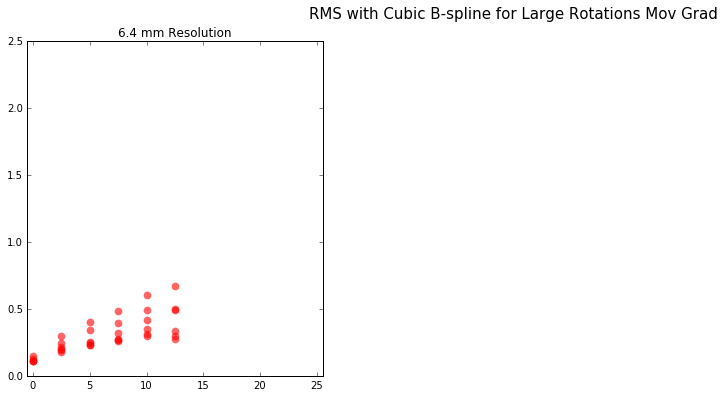

In [69]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Cubic B-spline for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,2.5])
    for i in xrange(70):
        plt.scatter(RMS_bspline[0][i][0], RMS_bspline[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Cubic B-spline for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,30])
    for i in xrange(70):
        plt.scatter(RMS_bspline1[0][i][0], RMS_bspline1[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

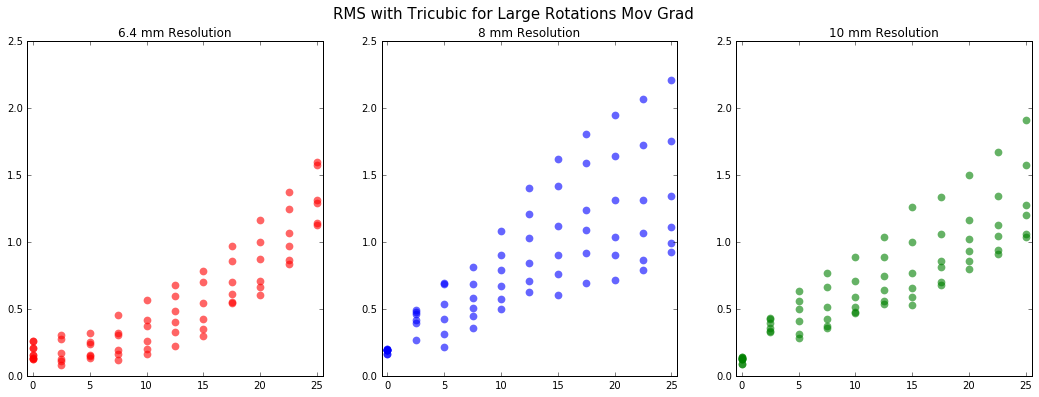

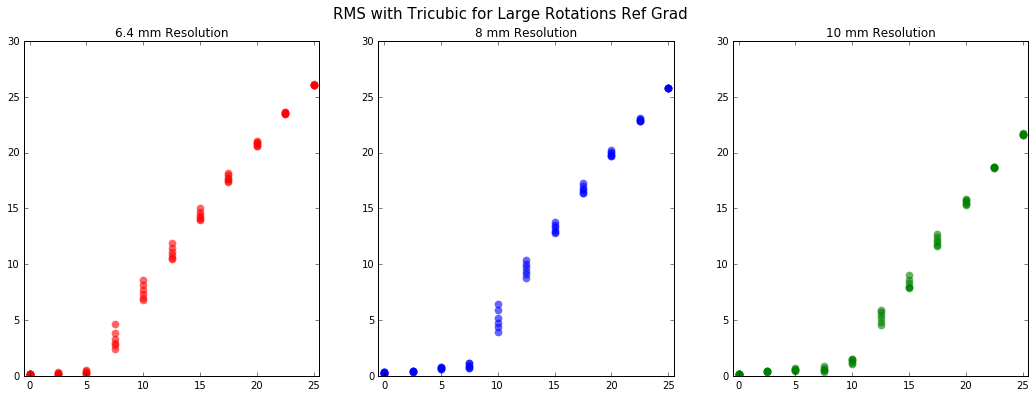

In [19]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Tricubic for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,2.5])
    for i in xrange(70):
        plt.scatter(RMS_cubic[0][i][0], RMS_cubic[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Tricubic for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,30])
    for i in xrange(70):
        plt.scatter(RMS_cubic1[0][i][0], RMS_cubic1[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

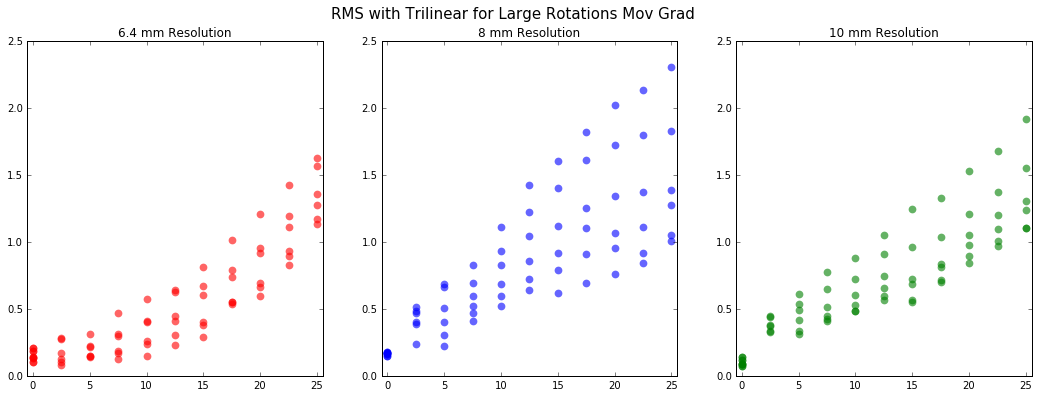

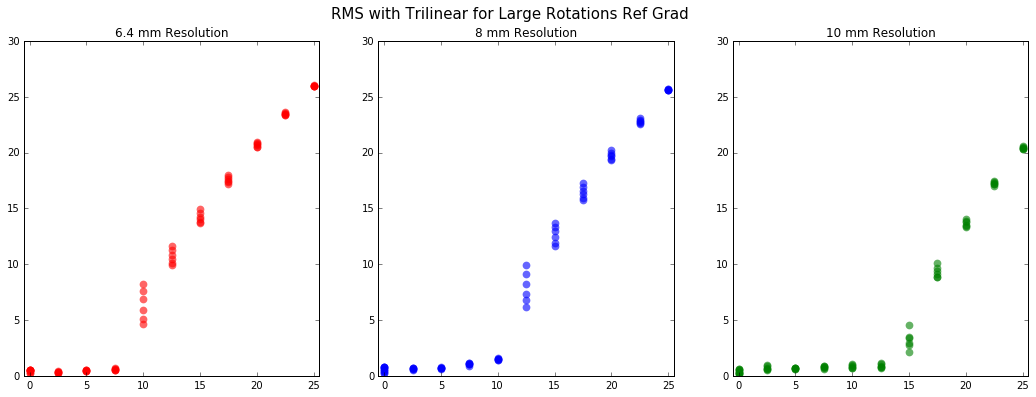

In [21]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Trilinear for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,2.5])
    for i in xrange(70):
        plt.scatter(RMS_linear[0][i][0], RMS_linear[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Trilinear for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(1,4):
    plt.subplot(1,3,idx)
    plt.title(resolutions[idx-1] + ' mm Resolution')
    plt.xlim([-0.5,25.5])
    plt.ylim([0,30])
    for i in xrange(70):
        plt.scatter(RMS_linear1[0][i][0], RMS_linear1[idx][i], lw = 0, s = 60, c = colors[idx-1], alpha = 0.6)
plt.show()

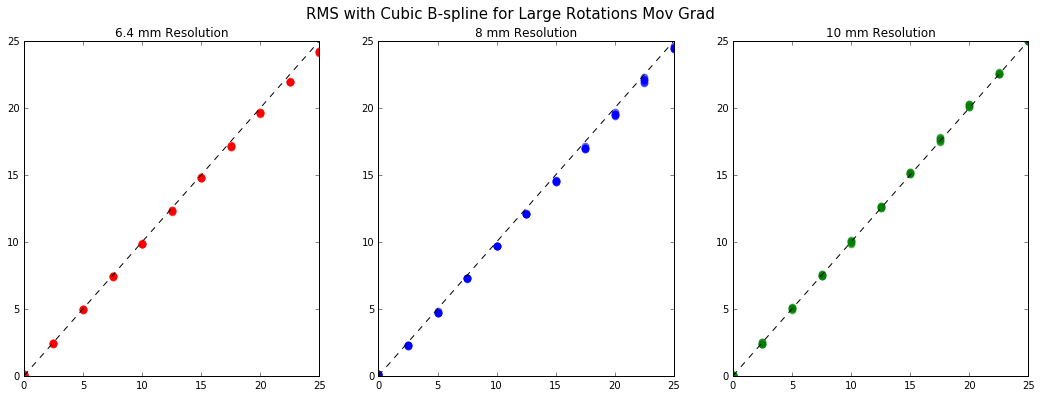

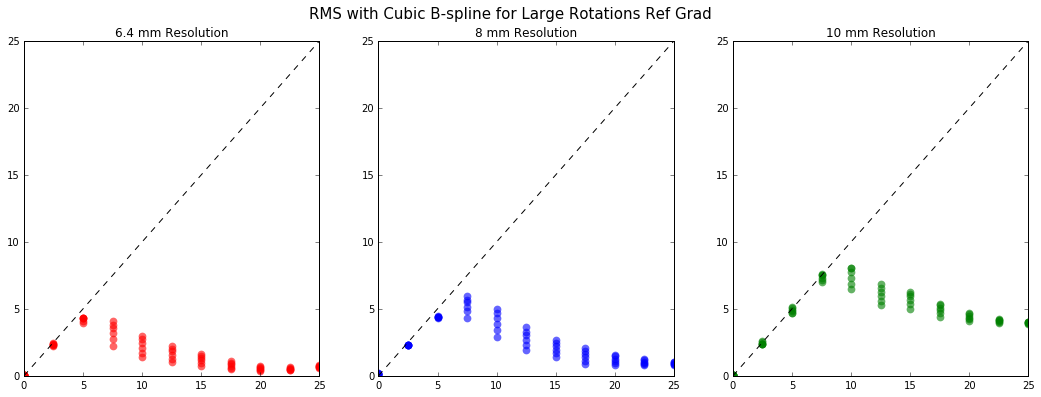

In [23]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Cubic B-spline for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_bspline[0][i][0], RMS_bspline[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Cubic B-spline for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_bspline1[0][i][0], RMS_bspline1[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

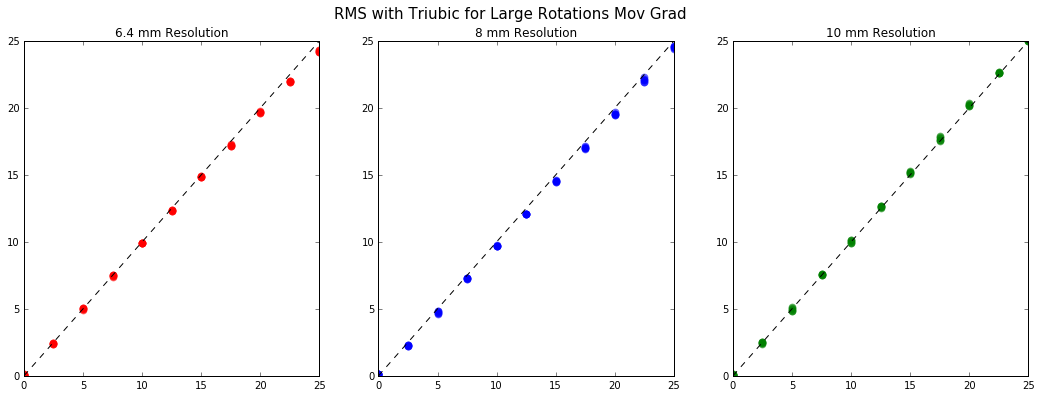

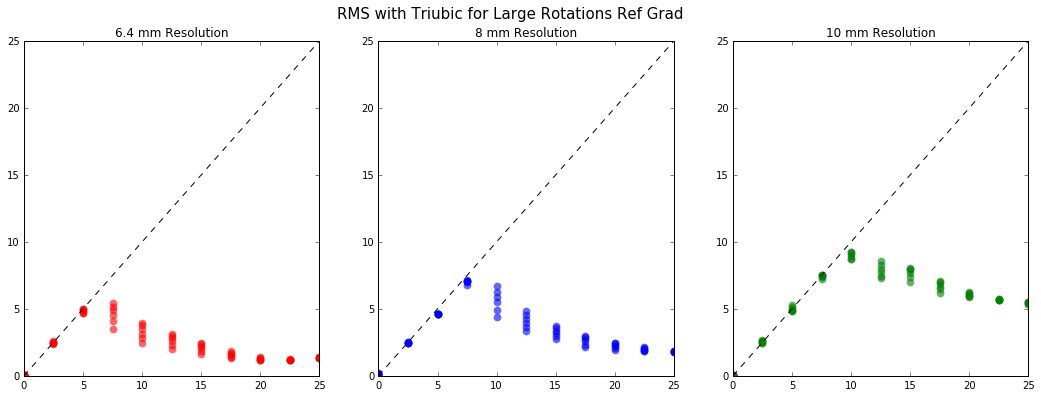

In [24]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Triubic for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_cubic[0][i][0], RMS_cubic[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Triubic for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_cubic1[0][i][0], RMS_cubic1[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

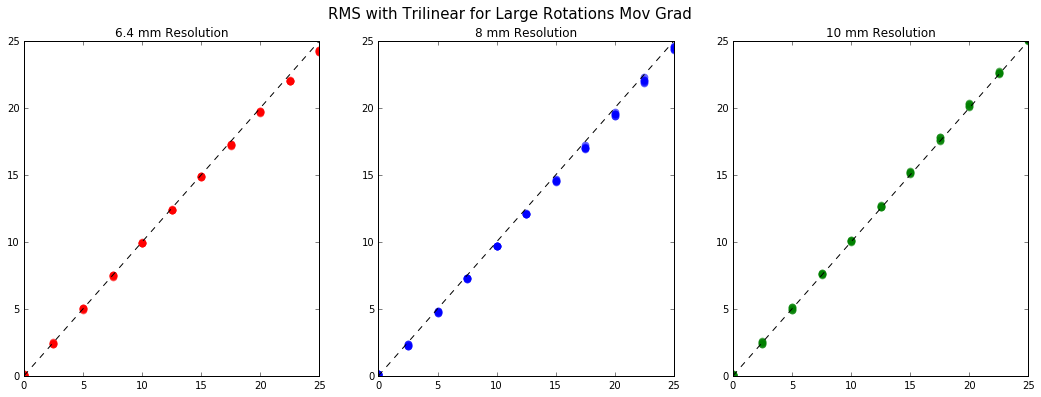

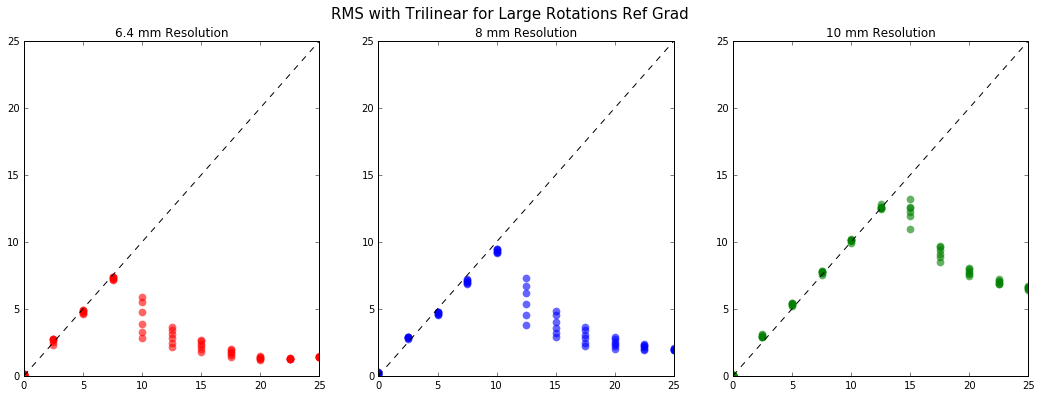

In [25]:
plt.figure(figsize = [18,6])
plt.suptitle('RMS with Trilinear for Large Rotations Mov Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_linear[0][i][0], RMS_linear[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

plt.figure(figsize = [18,6])
plt.suptitle('RMS with Trilinear for Large Rotations Ref Grad\n', fontsize = 15)
for idx in xrange(4,7):
    plt.subplot(1,3,idx-3)
    plt.title(resolutions[idx-4] + ' mm Resolution')
    plt.plot([0,25],[0,25],color = 'black',linestyle= '--')
    plt.xlim([0,25])
    plt.ylim([0,25])
    for i in xrange(70):
        plt.scatter(RMS_linear1[0][i][0], RMS_linear1[idx][i], lw = 0, s = 60, c = colors[idx-4], alpha = 0.6)
plt.show()

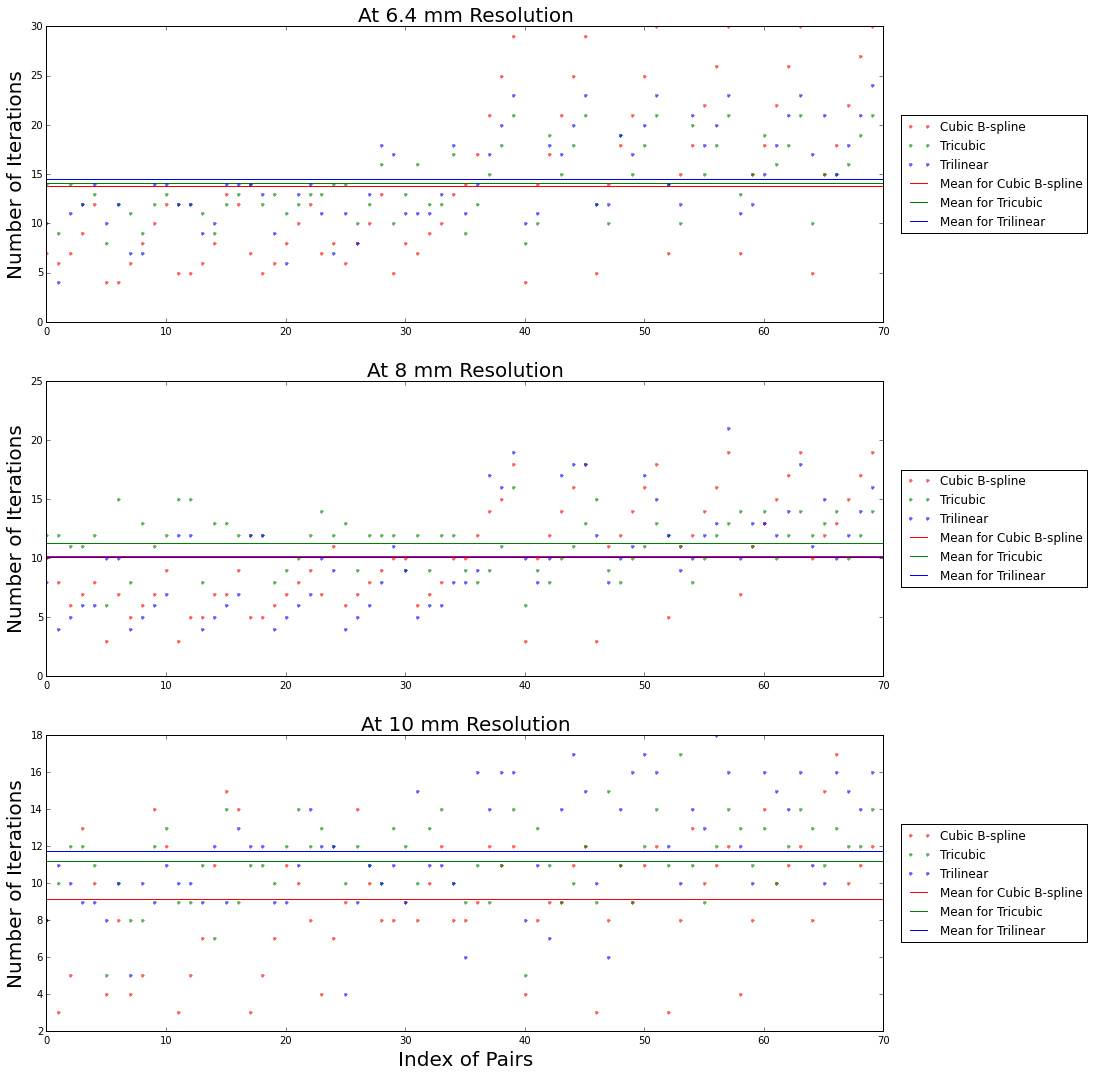

In [25]:
# Moving Gradient
res = ['6.4','8','10']
fontsize = 20
plt.figure(figsize = [15,18])
for i in [-3, -2, -1]:
    plt.subplot(3,1, i+4)
    plt.plot(RMS_bspline[i],'r.', label = 'Cubic B-spline', alpha = 0.6)
    plt.hlines(np.mean(RMS_bspline[i]),0, 70, 'r', label = 'Mean for Cubic B-spline')
    plt.plot(RMS_cubic[i],'g.', label = 'Tricubic', alpha = 0.6)
    plt.hlines(np.mean(RMS_cubic[i]),0, 70, 'g', label = 'Mean for Tricubic')
    plt.plot(RMS_linear[i],'b.', label = 'Trilinear', alpha = 0.6)
    plt.hlines(np.mean(RMS_linear[i]),0, 70, 'b', label = 'Mean for Trilinear')
    plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
    plt.title('At %s mm Resolution' % res[i], fontsize = fontsize)
    if(i == -1):
        plt.xlabel('Index of Pairs', fontsize = fontsize)
    plt.ylabel('Number of Iterations', fontsize = fontsize)
plt.show()

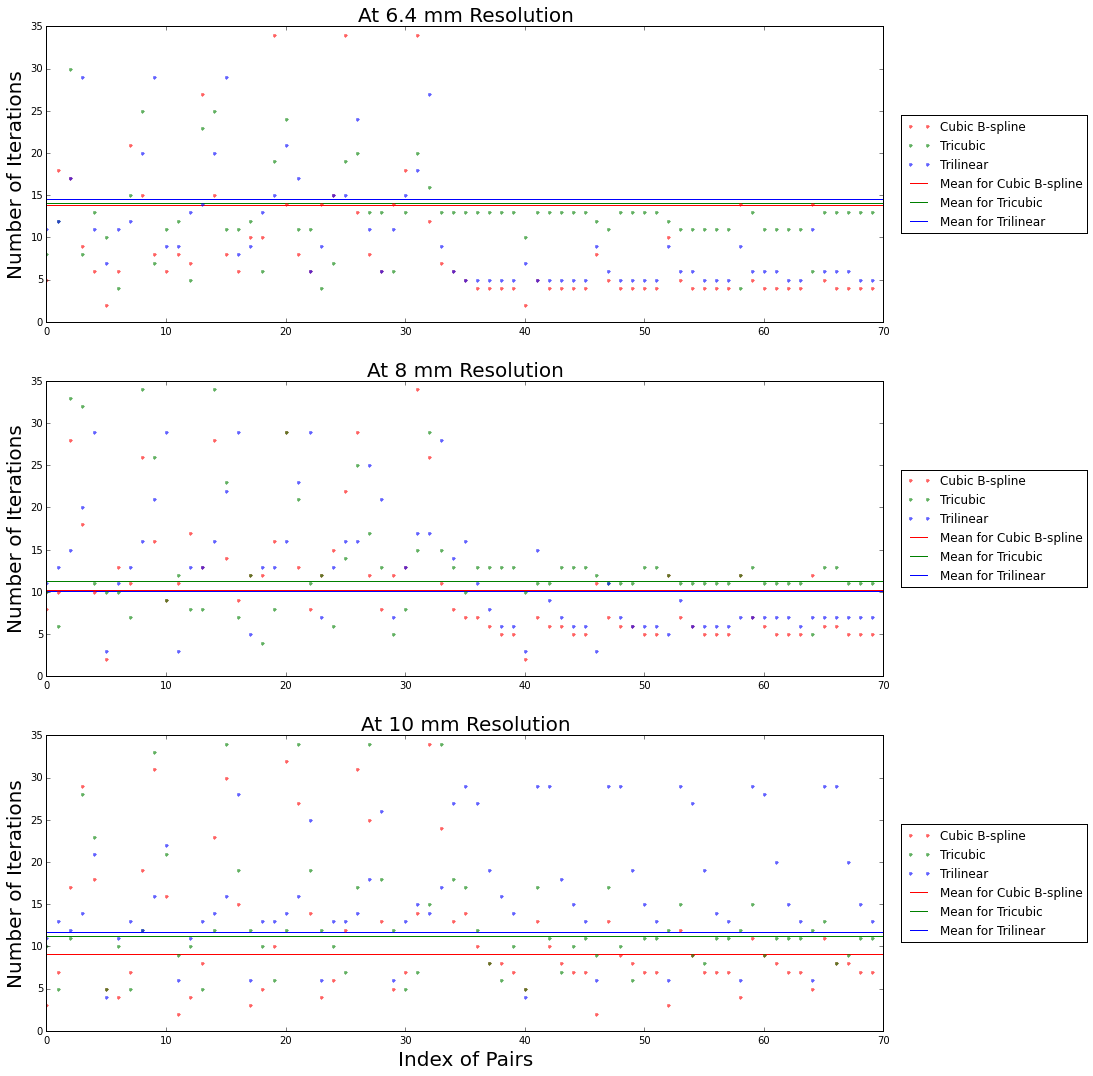

In [26]:
# Reference Gradient
res = ['6.4','8','10']
fontsize = 20
plt.figure(figsize = [15,18])
for i in [-3, -2, -1]:
    plt.subplot(3,1, i+4)
    plt.plot(RMS_bspline1[i],'r.', label = 'Cubic B-spline', alpha = 0.6)
    plt.hlines(np.mean(RMS_bspline[i]),0, 70, 'r', label = 'Mean for Cubic B-spline')
    plt.plot(RMS_cubic1[i],'g.', label = 'Tricubic', alpha = 0.6)
    plt.hlines(np.mean(RMS_cubic[i]),0, 70, 'g', label = 'Mean for Tricubic')
    plt.plot(RMS_linear1[i],'b.', label = 'Trilinear', alpha = 0.6)
    plt.hlines(np.mean(RMS_linear[i]),0, 70, 'b', label = 'Mean for Trilinear')
    plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
    plt.title('At %s mm Resolution' % res[i], fontsize = fontsize)
    if(i == -1):
        plt.xlabel('Index of Pairs', fontsize = fontsize)
    plt.ylabel('Number of Iterations', fontsize = fontsize)
plt.show()

In [41]:
N = 70
W = N*(N+1)/2.
sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
print (W-0.5)/sigma_w

7.26987386206


## The Wilcoxon Signed-Rank Test

In [34]:
# Trilinear RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[2],RMS_linear[3])
print 'Trilinear RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[2])
print 'Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[3])
print 'Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Trilinear RMS from 10mm to 8mm (8mm - 10mm) 70 2485.0 1801.0 5.26842740537
Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm) 70 2485.0 -1907.0 -5.58151917564
Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm) 70 2485.0 -1757.0 -5.142605479


In [35]:
# Tricubic RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[2],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[2])
print 'Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Tricubic RMS from 10mm to 8mm (8mm - 10mm) 70 2485.0 1853.0 5.42058415354
Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm) 70 2485.0 -1885.0 -5.5171451668
Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm) 70 2485.0 -1719.0 -5.03141400918


In [37]:
# Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[2],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[2])
print 'Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm) 70 2485.0 2025.0 5.92387185902
Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm) 70 2485.0 -1987.0 -5.81560648052
Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm) 70 2485.0 -1721.0 -5.0372661918


In [38]:
idx = 3
# 10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 70 2485.0 -953.0 -2.79002806499
10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 70 2485.0 -1445.0 -4.22966498998
10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 70 2485.0 -1285.0 -3.76149038023


In [39]:
idx = 2
# 8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 70 2485.0 -1305.0 -3.82001220645
8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 70 2485.0 -1787.0 -5.23038821833
8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 70 2485.0 -1679.0 -4.91437035674


In [40]:
idx = 1
# 6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 70 2485.0 281.0 0.820768612722
6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 70 2485.0 -363.0 -1.06363419153
6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 70 2485.0 -531.0 -1.55521753177
